# Tutorial on Posen and Levinthal (2012)  

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by Hart Posn and Dan Levinthal, published in 2012 in Management Science.  

This tutorial provides a barebones description of the model. If you want to explore a more flexible version or explore how different agents or bandit distributions would affect Hart's and Dan's results please follow the posen_levinthal.ipynb tutorial instead.  

**Reference:** Posen, H. E., & Levinthal, D. A. (2012). Chasing a moving target: Exploitation and exploration in dynamic environments. Management Science, 58(3), 587-601.  


# Basic Building Blocks

In this first sections, I will present the basic building blocks. Namely, the àgent's learning and decision processes and how we generate options in the environment.

## Agents
The agents follow a few simple actions. 

### 1. Choose
The agents choose one option based upon their attraction to this option. In this model, we use softmax, greedy, and e-greedy, as the rules for transforming the different attractions for each option into probabilities of choosing one option.   
* If the agent selects options via softmax, The agent's level of exploration is determined by the parameter tau. A small tau leads to high exploitation, a high tau to infinite exploration. Due to limitations in the floating point operation we cannot use taus lower that 0.002.  
* If greedy is chosen, there is no free parameter to specify the level exlorativeness of the agent.  
* If e-greedy is chosen, then the e parameter specifies the percentage of times the agent chooses an option other than the greedy one.  

### 2. Update
Updating is done via the Bush-Mossteller equation. The parameter phi determins how much the agent updates its beliefs based upon new information. A value of zero leads to agents to not update their beliefs. A value of one to full update of beliefs. A mixture leads to what is known as an Exponentially Recency Weighted Average (Sutton and Barto, 1998). The phi varies according to 1/(ki+1) where ki is the number of times an option has been tried. 

### 3. Learn
Learn is a subroutine. It receives two parameters, the number of periods and the bandits to learn from. 
It initalizes three lists and starts a for loop that run for the specified number of periods.
The period starts by asking the agent to choose an option. The payoff of the option is calculated by measuring the option's value. The period ends with the updating of the agent's attractions and the storage of the choice and payoff. After this a new period starts, the choices are stored and returned to the user.

**Note:** The agent calculates its knowledge of the environment. This is technically impossible as it needs to ask the environment for the true probabilities of the bandits. 

### 4. Reset
This function resets the attractions of the agent. It takes two values, the probabilities of drawing a 1 of each bandit and the starting attraction to each bandit. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(tau, attraction): #softmax action selection with attraction vector as parameters
    denom = np.sum(np.exp((attraction[:])/tau))
    probabilities = np.exp(attraction/tau)/denom
    choice = np.random.choice(range(len(probabilities)), p = probabilities)
    return(choice)

class agent:
    def __init__(self, tau, phi, style_choose):
        self.tau = tau
        self.phi = phi
        self.style_choose = style_choose
    def choose(self):
        if self.style_choose == "softmax": choice = softmax(self.tau, self.attraction)
        elif self.style_choose == "greedy": choice = np.argmax(self.attraction)
        elif type(self.style_choose) == float: # for e-greedy you pass the e parameter only
            best_choice = np.argmax(self.attraction)
            other_choice = best_choice
            while other_choice == best_choice: other_choice = np.random.choice(range(len(self.attraction))) #lazy
            choice = np.random.choice([best_choice,other_choice], p = [1-self.style_choose,self.style_choose])
        return(choice)
    def learn(self, num_periods, bandits):
        choices = []
        payoffs = []
        knowledge = []
        for i in range(num_periods):
            choice = self.choose()
            payoff = bandits.measure(choice)
            nugget = 1-sum((self.attraction-bandits.means)**2)
            self.update(choice, payoff)
            choices.append(choice)
            payoffs.append(payoff)
            knowledge.append(nugget)
        return([choices, payoffs, knowledge])
    def reset(self, means, att):
        self.attraction = np.ones(len(means))/2.0
        self.times = np.zeros(len(means))
    def update(self, choice, payoff):
        self.times[choice] += 1 #starts in 1
        self.attraction[choice] += (payoff-self.attraction[choice])/(self.times[choice]+1) # divides by 2

## Environment
The environment is composed of an n-arm bandit. Each arm of the bandit is definied by an object of class bandit. Put together these objects create one object of class bandits. 

### 1. Bandit
The bandit is a simple structure. It has a mean and a standard deviation. The style determines whether the bandit outputs an uniformly distributed value, a normally distributed value, or one without noise.

#### Measure
The bandits perform one function, when called upon, they give one output. The output is the draw of a binomial distribution with probablity given at the start of the simulation.

In [2]:
class bandit:
    def __init__(self, mean, noise = 0.0):
        self.mean = mean
        self.noise = noise
    def measure(self): return(np.random.binomial(n = 1, p = self.mean))

### 2. Bandits_P_L
This class creates the environment for the Posen and Levinthal (2012) paper. In specific, 10 bandits with probabilities of drawing 1s drawn from a Beta(2,2) distribution.

#### Measure
This is a wrapper function. The objective is that the agents ask the bandits class and not the specific bandit for the measurement. Then the bandits class is in charge of asking its bandit for the performance value.  
The second role of this function is to determine if a bandit needs to be changed and if so change it. This process is what Posen and Levinthal call turbulence and is determined by the eta parameter. 

#### Make Bandit
This function creates the bandits. As in this model the bandits need to be remade on every iteration, we need a simple way of remaking the bandits. These function makes a new bandit and stores the mean value of its output.  

#### Reset
This function makes new bandits for every arm of the bandit.

In [3]:
class bandits_P_L:
    def __init__(self, num_bandits, eta=0.0):
        self.eta = eta
        self.means = np.zeros(num_bandits)
        self.arms = ['']*num_bandits
    def make_bandit(self, position):
        self.means[position] = np.random.beta(a=2.0, b=2.0)
        self.arms[position] = bandit(mean = self.means[position]) # noise is not needed
    def measure(self, choice):
        # Change some arms?
        if np.random.binomial(n=1, p = self.eta):
            for i in range(len(self.arms)):
                if np.random.binomial(n=1, p = 0.5): self.make_bandit(i)
        return(self.arms[choice].measure())
    def reset(self): 
        for i in range(len(self.arms)): self.make_bandit(i)

# Simulation

With these two building blocks, we can run a simulation to replicate the main findings of Posen and Levinthal (2021).

## 1. Initialize values
We start by initailizing the attributes of the simulation. The agents are given a tau but do not require phi because the learning method follows the 1/k+1 weighting. The agents will learn for 500 periods and the results replicated 1000 times. There is no noise value here because in this paper the bandits either output a positive value or not. Changes in the tau, and bandit style should change the learning. Changes in the number of repetitions lead to more noisy results.

In [4]:
## Bandit
num_bandits = 10
eta = 0.0 # turbulence
## Agents
style_choose = "softmax" # "softmax", "greedy", or e value as float for e-greedy
phi = 0.5 # not needed in "over k" updating mode
tau = 0.5/num_bandits
att_0 = np.ones(num_bandits)/2.0
## Simulation
num_periods = 500
num_reps = 1000

## 2. Initialize agent and Bandits
We create one agent, Alice and initialize the environment for the paper. We create an environment with 10 bnadits. These bandits are different from the ones in the other papers as they are created from a Beta distribution of payoff probabilties. 

In [5]:
Alice = agent(tau = tau, phi = phi, style_choose = style_choose)
options = bandits_P_L(num_bandits = num_bandits, eta = eta)

## 3. Run simulation
Having the agent and environment we can run a simulation. We initialize two arrays, one for payoff and one for choices. Additionally, we create an empty list to store the last choices of the agents and one value to save the attraction to the option with variable output after every replication of the simulation is finished.

This takes some time.

In [6]:
all_payoffs = np.zeros(num_periods)
all_knowledge = np.zeros(num_periods)
all_RE = np.zeros(num_periods)
for j in range(num_reps):
    Alice.reset(means = options.means, att = np.ones(num_bandits)/2.0)
    options.reset()
    choice, payoff, knowledge = Alice.learn(num_periods, options)
    all_payoffs += payoff
    all_knowledge += knowledge
    # Calculate exploration
    all_RE[0] += 1
    for i in range(len(choice)-1):
        if choice[i+1]!=choice[i]: all_RE[i+1] +=1

## 4. Display results

### Amount of exploration
First we present the amount of exploration done by the agents. 

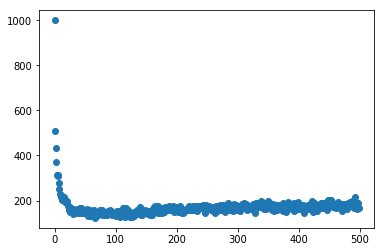

In [7]:
plt.scatter(range(num_periods), all_RE)

## Knowledge over time
Somthing quite sad happens for the amount of knowledge over time in this paper. Given the way the Bush Mossteller equation is updated, 1/k+1 and not with a constant update percentage, initial values have much more weight that later values. This leads to the system to erode knowledge. **Fast!**

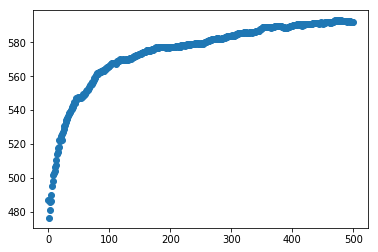

In [8]:
plt.scatter(range(num_periods), all_knowledge)

### Probability of Getting a Reward
The second graph presents the average payoff. This looks like a funnel, narrowing from left to right. As the stable option is chosen more and more, the variance in the performanc decreases. 

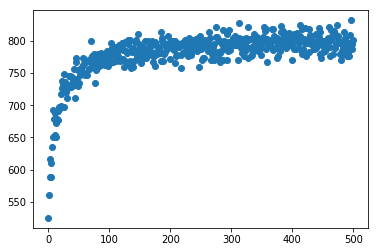

In [9]:
plt.scatter(range(num_periods), all_payoffs)

### Summary variables
#### Total accumulated payoff
The bandits in this paper give a payoff of 1 or -1, so one needs to recalculate the total payoff. So that it matches what is shown in the paper. In the simulation I store the probability of getting a 1, here, the actual expected value.

The result shown below is the performance of figure 1 in Posen and Levinthal (2012).

In [10]:
print(sum(2*all_payoffs-num_reps)/num_reps)

280.174


#### Fraction of exploration events
The average percentage of exploration events during the 500 periods, see Figure 1 in Posen and Levinthal (2012) for comparison. 

In [11]:
print(sum(all_RE)/(num_reps*num_periods))

0.170028


#### Knowledge
The average SSE knowledge at different stages of the simulation. This result is shown in Figure 1 of Posen and Levinthal (2012) and in Figure 4 when the turbulence changes. 

In [12]:
print("Period 400: " + str(all_knowledge[-101]/num_reps))
print("Period 500: " + str(all_knowledge[-1]/num_reps))

Period 400: 0.5897789635121388
Period 500: 0.5918216980313309


## 5. Exercise
What would happen if Posen and Levinthal had chosen other learning rules? They studied e-greedy but how about constant update? How woud it affect the erosion of knowledge and the adaptation of the agents? How does it change when the environment improves or gets worse?
